# Recommender system exercises

You'll need to install the packages pandas and matplotlib for this exercise.

We're working with the movielens data set, the smaller version. This data set contains 100k ratings for 9000 movies from 600 users.

We'll have a look at the data, implement collaborative filtering, and look at some typical metrics.

## Getting the data

Uncomment the lines in the next box and this will download the files and unzip them in this directory.


In [2]:
# Do this only once!
#wget "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
#unzip ml-latest-small.zip

SyntaxError: invalid syntax (<ipython-input-2-b8b66639fe1e>, line 2)

These are the includes for the rest of the notebook

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib as mpl

## Reading the movie data

Let's start by reading the movie data and define a function findMovieByTitle that returns all movies which match a given string.

We'll use the [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html) library for loading. Key to performance is to not manually iterate over the data, but use built-in functions as much as possible.

In [2]:
movies = pd.read_csv('ml-latest-small/movies.csv', index_col='movieId') # why is it called index_col, not index

                                             title  \
movieId                                              
1                                 Toy Story (1995)   
2                                   Jumanji (1995)   
3                          Grumpier Old Men (1995)   
4                         Waiting to Exhale (1995)   
5               Father of the Bride Part II (1995)   
...                                            ...   
193581   Black Butler: Book of the Atlantic (2017)   
193583                No Game No Life: Zero (2017)   
193585                                Flint (2017)   
193587         Bungo Stray Dogs: Dead Apple (2018)   
193609         Andrew Dice Clay: Dice Rules (1991)   

                                              genres  
movieId                                               
1        Adventure|Animation|Children|Comedy|Fantasy  
2                         Adventure|Children|Fantasy  
3                                     Comedy|Romance  
4                     

Implement a function findMovieByTitle that returns all movies whose title matches the string passed.

Then, let's return all movies containing the term 'Matrix'

In [3]:
# a function to do some exploration
def findMovieByTitle(title):
    return movies[movies.title.str.find(title) != -1]

findMovieByTitle('Matrix')

,title,genres
movieId,,
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
6365,"Matrix Reloaded, The (2003)",Action|Adventure|Sci-Fi|Thriller|IMAX
6934,"Matrix Revolutions, The (2003)",Action|Adventure|Sci-Fi|Thriller|IMAX


## Reading the ratings data

Next, we'll load the ratings data set. Use datetime.datetime.fromtimestamp to convert the timestamp column to an actual datetime object (this will make it more readable)

In [4]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.timestamp = ratings.timestamp.apply(datetime.datetime.fromtimestamp) # datetime.datetime WTF

userIds = ratings.userId.unique()

Now, define a function ratingsForUser that takes a user id and returns all the entries from the ratings table for that user.

In [5]:
# again, another function to find some data
def ratingsForUser(uid):
    return ratings[ratings["userId"] == uid]

ratingsForUser(20)

,userId,movieId,rating,timestamp
2977,20,2,3.0,2003-05-27 14:25:13
2978,20,8,1.0,2003-05-27 14:27:02
2979,20,13,4.0,2003-05-27 14:27:05
2980,20,34,4.0,2003-05-27 14:21:33
2981,20,48,5.0,2003-05-27 14:25:57
...,...,...,...,...
3214,20,6297,4.0,2003-05-27 13:57:50
3215,20,6333,4.0,2003-05-27 13:56:56
3216,20,6345,5.0,2003-05-27 13:57:03
3217,20,6358,3.5,2003-05-28 20:45:05


Let's do some data exploration. Compute the number of ratings per user and plot the histogram. Hint, use the [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) function from pandas. 

userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Name: rating, Length: 610, dtype: int64


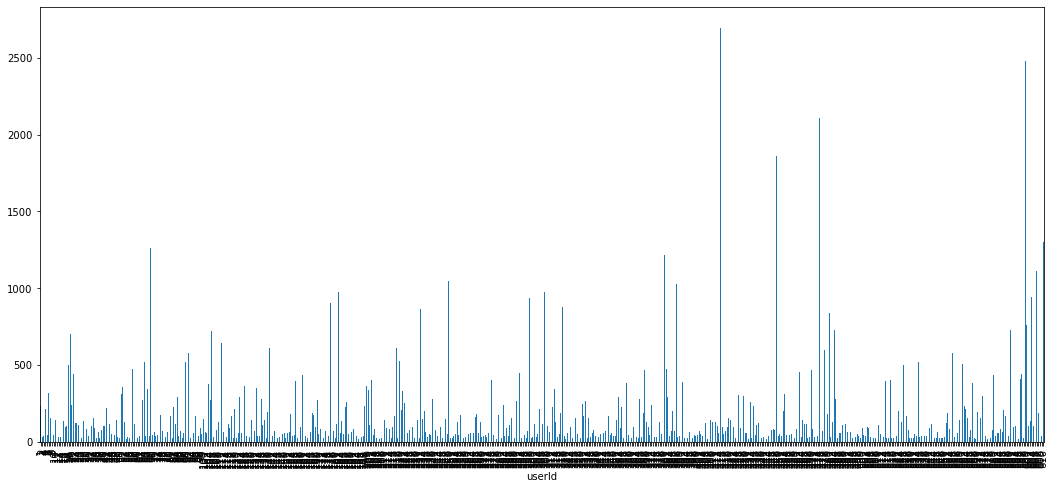

In [6]:
# compute a histogram of number of ratings.
#TODO
ratingsPerUser = ratings.groupby("userId").count()
ratingsPerUser = ratingsPerUser["rating"]
ratingsPerUser.plot.bar(figsize=(18,8))

This data set looks highly skewed as often the case. Most users have only a small number of ratings. What is the minimum number of ratings in the data set?

In [7]:
ratingsPerUser.min()

20

What is the movie with the most views?

In [8]:
ratingsPerMovie = ratings.copy()
countRatings = ratings.copy()
countRatings = ratingsPerMovie.groupby("movieId").count()
countRatings.rename(columns = {'rating':'numberOfRatings'}, inplace = True)
countRatings = countRatings.drop(columns= ["userId", "timestamp"])
ratingsPerMovie = ratingsPerMovie.join(countRatings, on="movieId")
ratingsPerMovie = ratingsPerMovie.sort_values(by='numberOfRatings', ascending=False)

       userId  movieId  rating           timestamp  numberOfRatings
79234     491      356     4.5 2018-04-01 19:52:26              329
58122     381      356     4.0 2010-07-09 01:46:16              329
53204     352      356     5.0 2017-05-04 23:08:06              329
40993     276      356     5.0 1997-03-14 15:53:02              329
17272     111      356     5.0 2018-01-16 23:13:13              329
...       ...      ...     ...                 ...              ...
97348     605    66240     3.5 2010-06-22 05:18:45                1
17861     111   167634     4.5 2018-01-17 02:52:13                1
4712       28    60735     2.5 2009-02-17 07:56:18                1
97353     605    71160     3.0 2010-06-22 05:01:55                1
69712     448    48262     4.0 2008-03-10 14:02:32                1

[100836 rows x 5 columns]
userId                             491
movieId                            356
rating                             4.5
timestamp          2018-04-01 19:52:26
n

This is a all not very informative. Try joining the movies data to this result set so that you can see the title and the other columns as well. (Hint: you need to use the 'on=' keyword int he join function)

In [9]:
ratingsPerMovie = ratingsPerMovie.join(movies["title"], on="movieId")
ratingsPerMovie.sort_values(by='numberOfRatings', ascending=False)

ratingsPerMovie

,userId,movieId,rating,timestamp,numberOfRatings,title
79234,491,356,4.5,2018-04-01 19:52:26,329,Forrest Gump (1994)
58122,381,356,4.0,2010-07-09 01:46:16,329,Forrest Gump (1994)
53204,352,356,5.0,2017-05-04 23:08:06,329,Forrest Gump (1994)
40993,276,356,5.0,1997-03-14 15:53:02,329,Forrest Gump (1994)
17272,111,356,5.0,2018-01-16 23:13:13,329,Forrest Gump (1994)
...,...,...,...,...,...,...
97348,605,66240,3.5,2010-06-22 05:18:45,1,Dead Like Me: Life After Death (2009)
17861,111,167634,4.5,2018-01-17 02:52:13,1,Fist Fight (2017)
4712,28,60735,2.5,2009-02-17 07:56:18,1,Shotgun Stories (2007)
97353,605,71160,3.0,2010-06-22 05:01:55,1,"Hunt For Gollum, The (2009)"


Likewise, what's the best rated movie of all times?

In [10]:
meanRating = ratings.copy()
meanRating = meanRating.groupby("movieId").mean()
meanRating.rename(columns = {'rating':'meanRating'}, inplace = True)
meanRating = meanRating.drop(columns= ["userId"])

ratingsPerMovie = ratingsPerMovie.join(meanRating, on="movieId")
ratingsPerMovie = ratingsPerMovie.sort_values(by='meanRating', ascending=False)

,userId,movieId,rating,timestamp,numberOfRatings,title,meanRating
16928,105,174551,5.0,2018-05-13 12:25:35,1,Obsession (1965),5.0
79429,493,876,5.0,2001-09-27 05:46:22,1,Supercop 2 (Project S) (Chao ji ji hua) (1993),5.0
16868,105,136445,5.0,2018-05-13 12:30:33,1,George Carlin: Back in Town (1996),5.0
13986,89,136353,5.0,2018-03-07 08:51:14,1,Scooby-Doo! and the Loch Ness Monster (2004),5.0
13987,89,136355,5.0,2018-03-07 08:51:06,1,Big Top Scooby-Doo! (2012),5.0
...,...,...,...,...,...,...,...
100797,610,145951,0.5,2017-05-04 00:03:39,1,Bloodsport: The Dark Kumite (1999),0.5
91709,594,7742,0.5,2005-02-21 02:51:10,1,Baxter (1989),0.5
69266,448,3933,0.5,2007-10-05 22:03:14,1,"Killer Shrews, The (1959)",0.5
87877,567,25782,0.5,2018-05-02 21:40:50,1,Boudu Saved From Drowning (Boudu sauvé des eau...,0.5


In [213]:
title="Belle"
ratingsPerMovie[ratingsPerMovie.title.str.find(title) != -1]

,userId,movieId,rating,timestamp,numberOfRatings,title,meanRating
77666,483,6442,5.0,2014-11-10 01:25:54,2,Belle époque (1992),5.000000
64142,414,6442,5.0,2003-06-10 19:25:07,2,Belle époque (1992),5.000000
49789,318,117849,4.5,2015-04-03 00:19:11,1,La Belle Verte (1996),4.500000
61848,410,154,4.0,2001-05-24 20:32:11,12,Beauty of the Day (Belle de jour) (1967),3.875000
22701,156,154,5.0,1999-10-13 21:19:56,12,Beauty of the Day (Belle de jour) (1967),3.875000
37980,260,154,4.5,2005-02-26 10:04:16,12,Beauty of the Day (Belle de jour) (1967),3.875000
13106,84,154,3.0,1997-03-19 12:43:38,12,Beauty of the Day (Belle de jour) (1967),3.875000
60419,391,154,4.0,2002-09-19 00:34:36,12,Beauty of the Day (Belle de jour) (1967),3.875000
48997,318,154,3.0,2014-12-27 16:49:00,12,Beauty of the Day (Belle de jour) (1967),3.875000
48709,315,154,4.0,1999-10-14 18:43:41,12,Beauty of the Day (Belle de jour) (1967),3.875000


The top seems to be movies with very few ratings, only look at movies that have twenty or more ratings.

In [212]:
ratingsPerMovie[ratingsPerMovie["numberOfRatings"] >= 20].sort_values(by='meanRating', ascending=False)

,userId,movieId,rating,timestamp,numberOfRatings,title,meanRating
24697,171,1104,5.0,1997-06-21 17:11:47,20,"Streetcar Named Desire, A (1951)",4.475000
93006,599,1104,3.0,2017-06-27 03:29:19,20,"Streetcar Named Desire, A (1951)",4.475000
60501,391,1104,5.0,2002-08-31 23:05:52,20,"Streetcar Named Desire, A (1951)",4.475000
13279,84,1104,4.0,1997-04-07 09:11:40,20,"Streetcar Named Desire, A (1951)",4.475000
88184,568,1104,5.0,2009-05-29 07:43:35,20,"Streetcar Named Desire, A (1951)",4.475000
...,...,...,...,...,...,...,...
93147,599,1499,2.0,2017-06-26 22:55:30,27,Anaconda (1997),1.925926
79416,492,1499,5.0,1997-05-18 19:37:35,27,Anaconda (1997),1.925926
23397,160,1499,1.0,2000-10-09 20:23:11,27,Anaconda (1997),1.925926
57076,380,1499,2.0,2017-05-08 23:27:26,27,Anaconda (1997),1.925926


# Toy data

Before we go into working on collaborative filtering, let's define a toy data set. This is generally good practice if you are working with real-world data sets. Toy data is smaller and you can work faster, but you can also design it in a way that you know the outcome.

In [12]:
toyratings = pd.DataFrame(data={
    'userId': [1, 1, 1, 1, 1,
              2, 2, 2,
              3, 3, 3],
    'movieId': [1,2,3,4,8,
               1,2,3,
               2,3,5],
    'rating': [5.0, 4.0, 3.0, 2.0, 1.0,
               1.0, 2.0, 3.0,
               3.0, 3.0, 3.0],
    'timestamp': ['2021-01-01 10:00', '2021-01-02 08:00', '2021-01-03 09:00', '2021-01-04 10:00', '2021-01-05 11:00',
                 '2021-01-10 08:00', '2021-01-11 09:00', '2021-01-13 10:00',
                '2021-01-07 08:00', '2021-01-09 09:00', '2021-01-11 10:00']
                  
})
toyratings

,userId,movieId,rating,timestamp
0,1,1,5.0,2021-01-01 10:00
1,1,2,4.0,2021-01-02 08:00
2,1,3,3.0,2021-01-03 09:00
3,1,4,2.0,2021-01-04 10:00
4,1,8,1.0,2021-01-05 11:00
5,2,1,1.0,2021-01-10 08:00
6,2,2,2.0,2021-01-11 09:00
7,2,3,3.0,2021-01-13 10:00
8,3,2,3.0,2021-01-07 08:00
9,3,3,3.0,2021-01-09 09:00


# Collaborative filtering

We will now (finally) implement collaborative filtering. For two movies, it looks at the ratings of all users and computes the cosine similarities between these vectors. It might sound simple, but works if you have sufficient amounts of data, and is often a good first version.

We're not dealing with this here, but for future reference: It is not personalized, and you don't know how to do recommendations for new items. There are other methods that look at customer events, or take content into account to deal with these kinds of problems. Factorization methods can also help if your data is very sparse.

Implement a function that takes the ratings dataframe and returns a dataframe which contains movie to movie similarities. You can convert the dataframe to a numpy array to work with matrix algebra. Try to avoid using explicit for loops.

Let's store the result in the _sims_ variable for the full rating data set and in the _ts_ variable for the toyratings.

In [140]:
import time 

def collaborative_filtering_slow(ratings):
    movies_ids = ratings["movieId"].unique()
    user_ids = ratings["userId"].unique()
    
    movie_ratings = np.zeros((len(user_ids), len(movies_ids)))
    
    for u_idx in range(len(user_ids)):
        print("user id : " + str(user_ids[u_idx]))
        begin = time.time()
        
        user_movies = ratings[ratings["userId"] == user_ids[u_idx]]
        for m_idx in range(len(movies_ids)):
            
            movie = user_movies[user_movies["movieId"] == movies_ids[m_idx]]
            if movie.empty:
                movie_ratings[u_idx, m_idx] = 0
            else:
                movie_ratings[u_idx, m_idx] = movie["rating"]            
            
        end = time.time()
        duration = end - begin
        print("duration for one user is : " + str(duration))
        
    print("Done Filling rating matrix")
    similarity_matrix = np.zeros((len(movies_ids), len(movies_ids)))
    for m1_idx in range(len(movies_ids)):
        for m2_idx in range(len(movies_ids)):
            # compute consine similarity
            a = movie_ratings[:, m1_idx]
            b = movie_ratings[:, m2_idx]
            similarity_matrix[m1_idx, m2_idx] = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm((b)))
    
    similarity_df = pd.DataFrame(similarity_matrix, columns=movies_ids, index=movies_ids)
    return similarity_df

def collaborative_filtering_fast(ratings):
    movies_ids = ratings["movieId"].unique()
    user_ids = ratings["userId"].unique()
    
    movie_ratings = np.zeros((len(user_ids), len(movies_ids)))
    
    begin = time.time()
    for row in ratings.itertuples():
        u_id = row[1]
        m_id = row[2]
        m_rating = row[3]
        
        m_idx = np.where(movies_ids == m_id)
        movie_ratings[u_id-1, m_idx[0][0]] = m_rating

        
    similarity_matrix = np.zeros((len(movies_ids), len(movies_ids)))
    for m1_idx in range(len(movies_ids)):
        for m2_idx in range(len(movies_ids)):
            # compute consine similarity
            a = movie_ratings[:, m1_idx]
            b = movie_ratings[:, m2_idx]
            similarity_matrix[m1_idx, m2_idx] = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm((b)))
    
    similarity_df = pd.DataFrame(similarity_matrix, columns=movies_ids, index=movies_ids)
    return similarity_df

sims = collaborative_filtering_slow(toyratings)
sims

duration for matrix filling is : 1.4401822090148926
Done Filling rating matrix
          1         3         6         47        50        70        101     \
1       1.000000  0.296917  0.376316  0.437659  0.441003  0.243044  0.214393   
3       0.296917  1.000000  0.284257  0.279614  0.204892  0.165353  0.169272   
6       0.376316  0.284257  1.000000  0.463926  0.456850  0.378518  0.174948   
47      0.437659  0.279614  0.463926  1.000000  0.578066  0.370548  0.201866   
50      0.441003  0.204892  0.456850  0.578066  1.000000  0.363251  0.265287   
...          ...       ...       ...       ...       ...       ...       ...   
160341  0.085070  0.000000  0.122878  0.086003  0.064942  0.147743  0.000000   
160527  0.085070  0.000000  0.122878  0.086003  0.064942  0.147743  0.000000   
160836  0.085070  0.000000  0.122878  0.086003  0.064942  0.147743  0.000000   
163937  0.085070  0.000000  0.122878  0.086003  0.064942  0.147743  0.000000   
163981  0.085070  0.000000  0.122878  0.0

In [ ]:
sims = collaborative_filtering(ratings)
print(sims)

ts = collaborative_filtering(toyratings)
ts

For getting recommendations quickly, let create another dataframe where each row is the ids of the recommendations. We get this by sorting the rows of the similarity dataframe.

Write a function _allrecos_ that takes the similarity matrix computed by _collaborative_filtering_ and returns another dataframe with the values such that the first column is the movie itself (highest similarity), the second column is the second most similar, and so on...

In [142]:
def allrecos(sims):
    sims_mat = sims.to_numpy()
    sims_mat_sorted = -np.sort(-sims_mat, axis=-1)
    sims_df_sorted = pd.DataFrame(sims_mat_sorted, index=sims.columns)
    similarity_sorted = sims_df_sorted.copy()
    for row in sims_df_sorted.index:
        series_sorted = sims_df_sorted.loc[row]
        series_raw = sims.loc[row]
        series_raw = series_raw.sort_values(ascending=False)
        sims_df_sorted.loc[row] = series_raw.index
        
    return sims_df_sorted, similarity_sorted

recos, similarity = allrecos(sims)
print(recos)

print(similarity)

            0        1        2        3        4        5        6     \
1            1.0   3114.0    480.0    780.0    260.0    356.0    364.0   
3            3.0   3450.0    762.0    788.0    736.0      5.0     95.0   
6            6.0    733.0     32.0    293.0     16.0    608.0    457.0   
47          47.0    296.0    593.0    110.0   1089.0    356.0     50.0   
50          50.0    296.0    318.0   1089.0   1213.0     47.0    593.0   
...          ...      ...      ...      ...      ...      ...      ...   
160341  163981.0  58826.0  71341.0  70208.0  70206.0  67168.0  66310.0   
160527  163981.0  58826.0  71341.0  70208.0  70206.0  67168.0  66310.0   
160836  163981.0  58826.0  71341.0  70208.0  70206.0  67168.0  66310.0   
163937  163981.0  58826.0  71341.0  70208.0  70206.0  67168.0  66310.0   
163981  163981.0  58826.0  71341.0  70208.0  70206.0  67168.0  66310.0   

           7        8        9     ...      9714      9715      9716  \
1        1210.0    648.0   1265.0  ... 

Finally, we define the function getReco that takes the recommendation dataframe, a movie id, and optinally a number of items to recommend and returns a 

In [65]:
def getReco(recos, mi, n=10):
    list_recos = recos.loc[mi][:n+1]
    list_recos = list_recos[list_recos != mi]
    return list_recos

getReco(recos, 4,3)

0    8.0
2    1.0
3    2.0
Name: 4, dtype: float64

As we did above, if we join with the movies table we can also see what we're recommending.

Write a function `printReco` that takes the recommendation table, a movie id, optionally a number of recommendations to return and joins the information from the movies table to the recommendations. Make it also output the title of the passed movie id.

Hint: you can use to_frame(name='movieId') to turn the recommendations into a dataframe that can be joined more easily with the movies dataframe.

In [143]:
def printReco(recos, mi, n=10):
    list_recos = getReco(recos, mi, n)
    print("Recommendations:")
    for mid in list_recos:
        print(movies.loc[mid]["title"])
    
printReco(recos, 1)

Recommendations:
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)
Back to the Future (1985)


What are the recommendations for the first Matrix movie?

In [174]:
recos, similarity = allrecos(sims)
movie = findMovieByTitle('Matrix')
printReco(recos, movie.index[0])

Recommendations:
Fight Club (1999)
Star Wars: Episode V - The Empire Strikes Back (1980)
Saving Private Ryan (1998)
Star Wars: Episode IV - A New Hope (1977)
Star Wars: Episode VI - Return of the Jedi (1983)
Lord of the Rings: The Fellowship of the Ring, The (2001)
Sixth Sense, The (1999)
Lord of the Rings: The Return of the King, The (2003)
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
Gladiator (2000)


What are the recommendations to 'When Harry Met Sally'?

In [175]:
movie = findMovieByTitle('When Harry Met Sally')
printReco(recos, movie.index[0])

Recommendations:
Big (1988)
Groundhog Day (1993)
Breakfast Club, The (1985)
Shakespeare in Love (1998)
Jerry Maguire (1996)
Stand by Me (1986)
E.T. the Extra-Terrestrial (1982)
Ghostbusters (a.k.a. Ghost Busters) (1984)
Splash (1984)
Mary Poppins (1964)


# Now let's compute some metrics

As you hopefully saw from the above examples, the algorithm seems to be making more or less sense. However, in practice, you'll want to define some metrics that can objectively measure how well the algorithm works. We're looking at two measures here, views@n and mean reciprocal rank@n.

The "@n" part measures how many recommendations you want.

views@n measure the percentage of recommendations that contained the next movie viewed by a users.

mrr@n measures the mean reciprocal rank: you take the position p of the item that has been viewed and take the 1/p and then take the mean over all recommendations.

This setting simulates a setting where we would have shown our recommendations after each view and measures whether we were able to recommend something that people viewed.

The analysis is very simple and also incorrect strictly speaking because our model has been trained on the views we are using to evaluate. Since the model is very simple, we'll probably not see overfitting.

## Looking at the next recommendation

As a first step, we need to collect pairs of movieId and next movieId from the ratings. The ratings table is already sorted by userIds, but the times are bit all over the place. Sort the ratings table first by userId and timestamp.

I personally didn't find a good way to do this with pandas operations, so iterate over the whole table. Or try to find a better solutions!

The end result should be a dataframe with the columns userId, movieId, nextMovieId, timestamp (of the first view).

In [176]:
# create a new dataframe with nextMovieId, if that is given in the same session.

ratings = ratings.sort_values(by="timestamp") #TODO
ratings["nextMovieId"] = 0
a = 0
for idx in ratings.index:
    if idx == ratings.index[0]:
        prev_idx = idx
        continue
        
    cur_row = ratings.loc[idx]
    prev_row = ratings.loc[prev_idx]
    if ratings.loc[idx]["userId"] == ratings.loc[prev_idx]["userId"]:
        # same user
        ratings.loc[prev_idx, ["nextMovieId"]] = ratings.loc[idx, ["movieId"][0]]
        
    elif ratings.loc[idx]["userId"] != ratings.loc[idx-1]["userId"]:
        # different users
        ratings.loc[prev_idx, ["nextMovieId"]] = 0
    
    
    prev_idx = idx
        
ratings

,userId,movieId,rating,timestamp,nextMovieId
66719,429,595,5.0,1996-03-29 19:36:55,468
66714,429,468,3.0,1996-03-29 19:36:55,22
66662,429,22,4.0,1996-03-29 19:36:55,150
66665,429,150,5.0,1996-03-29 19:36:55,161
66667,429,161,5.0,1996-03-29 19:36:55,165
...,...,...,...,...,...
81475,514,187031,2.5,2018-09-23 05:55:27,187595
81477,514,187595,3.0,2018-09-23 05:55:46,5247
81336,514,5247,2.5,2018-09-24 04:44:00,5246
81335,514,5246,1.5,2018-09-24 04:44:19,162


## Computing views@n

Now implement a function that computes the views@n metric.

Hint: Using "axis=1" in DataFrame#apply let's you run a function over the rows of a data frame. Define a helper function that gets the recommendations via getReco defined above and checks whether the nextMovieId is in the recommendations or not.

What value did you get for different n?

In [177]:
def viewsAtN(recos, n):
    # measure the percentage of recommendations that contained the next movie viewed by a users.
    countContaining = 0
    countAll = 0
    for row in ratings.itertuples():
        cur_movieId = row[2]
        next_movieId = row[5]
        
        list_recos = getReco(recos, cur_movieId, n)
        
        if next_movieId != 0:
            countAll += 1
            if next_movieId in list_recos:
                countContaining += 1
        
    
    percentage = (countContaining / countAll) * 100
    print(str(percentage) + " % of recommendations contained the next movie viewed by all user")
    return percentage

viewsAtN(recos, 10)
viewsAtN(recos, 20)
viewsAtN(recos, 50)


0.7659136930679565 % of recommendations contained the next movie viewed by all user
1.177198854277051 % of recommendations contained the next movie viewed by all user
2.6439760363441787 % of recommendations contained the next movie viewed by all user


2.6439760363441787

In [182]:
ratings

,userId,movieId,rating,timestamp,nextMovieId
66719,429,595,5.0,1996-03-29 19:36:55,468
66714,429,468,3.0,1996-03-29 19:36:55,22
66662,429,22,4.0,1996-03-29 19:36:55,150
66665,429,150,5.0,1996-03-29 19:36:55,161
66667,429,161,5.0,1996-03-29 19:36:55,165
...,...,...,...,...,...
81475,514,187031,2.5,2018-09-23 05:55:27,187595
81477,514,187595,3.0,2018-09-23 05:55:46,5247
81336,514,5247,2.5,2018-09-24 04:44:00,5246
81335,514,5246,1.5,2018-09-24 04:44:19,162


## Computing MRR@n

Just as above, compute a function that computes the MRR.

Hint, if you have a Python list l, you can use l.index(i) to get the index of item i.

In [194]:
def MRRAtN(recos, n):
    # measures the mean reciprocal rank: 
    # you take the position p of the item that has been viewed and take the 1/p 
    # and then take the mean over all recommendations
    mrr = 0
    countAll = 0
    for row in ratings.itertuples():        
        cur_movieId = row[2]
        next_movieId = row[5]
        
        list_recos = list(getReco(recos, cur_movieId, n))
        
        if next_movieId != 0:
            countAll += 1
            if next_movieId in list_recos:
                mid = next_movieId
                idx = list_recos.index(mid)+1
                mrr += 1/idx
            else:
                mrr += 0
                
    mrr = (mrr / countAll) * 100
    print(str(mrr) + " % mean reciprocal rank")
    return mrr

MRRAtN(recos, 10) 
MRRAtN(recos, 20)
MRRAtN(recos, 50)


3.065635074532268 % mean reciprocal rank
3.347420412341858 % mean reciprocal rank
3.605375801163438 % mean reciprocal rank


3.605375801163438

## Congratulations!

You did some exploratory analysis on user interaction data, build a simple recommendation model and did some evaluation. These are all steps you would be doing on a data science project.

Here are some things you would do in practice:

- more properly separate between training and test data.
- make the code more modular so you can evaluate arbitrary algorithms.
- Look into other methods, e.g. content based filtering. You could for example take the genre data, and suggest the most popular movie from a given genre.
- You could look into factorization methods like Alternate Least Squares or versions of non-negative matrix factorization. These are dimension-reduction methods that try to explain the ratings in terms of a smaller number of factors. These "compress" data and could help if the data is very sparse.
- Productionize the system. It is not uncommon for recommendation systems to compute all recommendations in a batch fashion and then just load the recommended items into a database. No need to run a ML model in production.

